In [ ]:
# Reference:https://github.com/Muhammad-MujtabaSaeed/102-Flowers-Classification/blob/master/102_Flowers_classification.ipynb

In [93]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
import torch.utils.data as data
from torchvision import datasets, models, transforms
import time
import json
import copy
import seaborn as sns
import numpy as np
from PIL import Image
from collections import OrderedDict
import matplotlib.pyplot as plt

In [94]:
data_dir = 'D:/Z-kobehsegu/Datasets/flower_png'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'

In [95]:
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    }

# TODO: Load the datasets with ImageFolder
# loading datasets with PyTorch ImageFolder
image_datasets = {
        x: datasets.ImageFolder(root=data_dir + '/' + x, transform=data_transforms[x])
        for x in list(data_transforms.keys())
    }

# TODO: Using the image datasets and the trainforms, define the dataloaders
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {
        x: data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
        for x in list(image_datasets.keys())
    }
dataset_sizes = {
        x: len(dataloaders[x].dataset) 
        for x in list(image_datasets.keys())
    } 
class_names = image_datasets['train'].classes

In [96]:
dataset_sizes

{'train': 3400, 'test': 1360}

In [97]:
class_names

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '6',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '7',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '8',
 '80',
 '81',
 '82',
 '83',
 '84',
 '9']

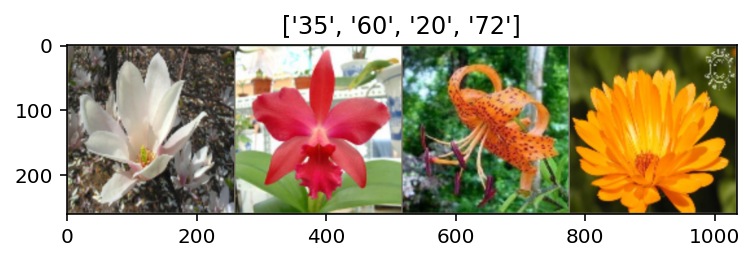

In [98]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [99]:
model_ft = models.resnet18(pretrained=False) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 102)
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
checkpoint = torch.load('D:/Z-kobehsegu/Jupyter/resnet18-5c106cde.pth')
#model_ft.load_state_dict(checkpoint['model'])
state_dict = checkpoint['state_dist']
optimizer_ft.load_state_dict(checkpoint['optim'])

NameError: name 'optimizer_ft' is not defined

In [100]:
use_gpu = torch.cuda.is_available() # if gpu is available then use it
if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss() # defining loss function


optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9) # defining optimizer with learning rate set to 0.0001

In [101]:
def train_model(model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                # print(labels)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                print(best_acc)
                best_model_wts = model.state_dict()
                # saving a checkpoint to use for next time to save time used in training from scratch
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'./point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [33]:
def visualize_model(model, num_images=8):
    images_so_far = 0
    fig = plt.figure()
    


    for i, data in enumerate(dataloaders['valid']):
        inputs, labels = data
        #print(labels)
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        print(labels)
        #_, lab = torch.max(labels.data, 1)
        outputs = model(inputs)
        #print(outputs)
        _, preds = torch.max(outputs.data, 1)
        #print(preds)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [102]:
model_ft = train_model(model_ft, criterion, optimizer_ft,num_epochs=200)

Epoch 0/199
----------
train Loss: 1.1281 Acc: 0.0197
tensor(0.0197, device='cuda:0')

Epoch 1/199
----------
train Loss: 1.0665 Acc: 0.0488
tensor(0.0488, device='cuda:0')

Epoch 2/199
----------
train Loss: 1.0133 Acc: 0.0671
tensor(0.0671, device='cuda:0')

Epoch 3/199
----------
train Loss: 0.9700 Acc: 0.0909
tensor(0.0909, device='cuda:0')

Epoch 4/199
----------
train Loss: 0.9331 Acc: 0.1021
tensor(0.1021, device='cuda:0')

Epoch 5/199
----------
train Loss: 0.9127 Acc: 0.1106
tensor(0.1106, device='cuda:0')

Epoch 6/199
----------
train Loss: 0.8919 Acc: 0.1279
tensor(0.1279, device='cuda:0')

Epoch 7/199
----------
train Loss: 0.8658 Acc: 0.1526
tensor(0.1526, device='cuda:0')

Epoch 8/199
----------
train Loss: 0.8521 Acc: 0.1629
tensor(0.1629, device='cuda:0')

Epoch 9/199
----------
train Loss: 0.8341 Acc: 0.1779
tensor(0.1779, device='cuda:0')

Epoch 10/199
----------
train Loss: 0.8145 Acc: 0.1906
tensor(0.1906, device='cuda:0')

Epoch 11/199
----------
train Loss: 0.7939

train Loss: 0.0858 Acc: 0.9400
tensor(0.9400, device='cuda:0')

Epoch 100/199
----------
train Loss: 0.0817 Acc: 0.9397

Epoch 101/199
----------
train Loss: 0.0776 Acc: 0.9485
tensor(0.9485, device='cuda:0')

Epoch 102/199
----------
train Loss: 0.0734 Acc: 0.9471

Epoch 103/199
----------
train Loss: 0.0762 Acc: 0.9488
tensor(0.9488, device='cuda:0')

Epoch 104/199
----------
train Loss: 0.0696 Acc: 0.9532
tensor(0.9532, device='cuda:0')

Epoch 105/199
----------
train Loss: 0.0683 Acc: 0.9565
tensor(0.9565, device='cuda:0')

Epoch 106/199
----------
train Loss: 0.0650 Acc: 0.9532

Epoch 107/199
----------
train Loss: 0.0595 Acc: 0.9621
tensor(0.9621, device='cuda:0')

Epoch 108/199
----------
train Loss: 0.0593 Acc: 0.9659
tensor(0.9659, device='cuda:0')

Epoch 109/199
----------
train Loss: 0.0589 Acc: 0.9609

Epoch 110/199
----------
train Loss: 0.0562 Acc: 0.9676
tensor(0.9676, device='cuda:0')

Epoch 111/199
----------
train Loss: 0.0540 Acc: 0.9676

Epoch 112/199
----------
tra

In [103]:
model_ft_2 = models.resnet18(pretrained=False) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft_2.fc.in_features
model_ft_2.fc = nn.Linear(num_ftrs, 102)

In [104]:
checkpoint = torch.load('D:/Z-kobehsegu/Jupyter/point_resnet_best.pth')
model_ft_2.load_state_dict(checkpoint['model'])
#state_dict = checkpoint['state_dist']
optimizer_ft.load_state_dict(checkpoint['optim'])

In [105]:
use_gpu = torch.cuda.is_available() # if gpu is available then use it
if use_gpu:
    model_ft_2 = model_ft_2.cuda()

criterion = nn.CrossEntropyLoss() # defining loss function


optimizer_ft = optim.SGD(model_ft_2.parameters(), lr=0.0001, momentum=0.9) # defining optimizer with learning rate set to 0.0001

In [106]:
data_dir = 'D:/Z-kobehsegu/Datasets/flower_png/test'
train_dir = data_dir + '/train'
var_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    }

# TODO: Load the datasets with ImageFolder
# loading datasets with PyTorch ImageFolder
image_datasets = {
        x: datasets.ImageFolder(root=data_dir + '/' + x, transform=data_transforms[x])
        for x in list(data_transforms.keys())
    }

# TODO: Using the image datasets and the trainforms, define the dataloaders
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {
        x: data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
        for x in list(image_datasets.keys())
    }
dataset_sizes = {
        x: len(dataloaders[x].dataset) 
        for x in list(image_datasets.keys())
    } 
class_names = image_datasets['train'].classes

In [107]:
def train_model(model, criterion, optimizer, num_epochs=30):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                print(labels)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                # saving a checkpoint to use for next time to save time used in training from scratch
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'./test_point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [108]:
model_ft_2 = train_model(model_ft_2, criterion, optimizer_ft,num_epochs=100)

Epoch 0/99
----------
tensor([15,  1, 10, 10], device='cuda:0')
tensor([ 2, 11, 13,  2], device='cuda:0')
tensor([14, 16, 14,  6], device='cuda:0')
tensor([ 5,  6,  0, 11], device='cuda:0')
tensor([10, 15,  5,  3], device='cuda:0')
tensor([13,  1, 13,  8], device='cuda:0')
tensor([14,  0, 10,  4], device='cuda:0')
tensor([15, 12,  0,  7], device='cuda:0')
tensor([15, 14,  2,  6], device='cuda:0')
tensor([10,  4, 15, 15], device='cuda:0')
tensor([7, 6, 5, 2], device='cuda:0')
tensor([11,  6, 12, 14], device='cuda:0')
tensor([ 4,  4,  1, 15], device='cuda:0')
tensor([11,  7, 14,  1], device='cuda:0')
tensor([ 2,  1,  6, 13], device='cuda:0')
tensor([16, 12,  6,  1], device='cuda:0')
tensor([14,  5,  4, 15], device='cuda:0')
tensor([2, 0, 8, 9], device='cuda:0')
tensor([ 0,  9, 11,  0], device='cuda:0')
tensor([2, 3, 9, 2], device='cuda:0')
tensor([ 1,  3,  3, 13], device='cuda:0')
tensor([4, 7, 3, 3], device='cuda:0')
tensor([ 9, 12,  1, 10], device='cuda:0')
tensor([10, 11, 14,  5], dev

tensor([ 5,  3, 14, 11], device='cuda:0')
tensor([ 4, 16,  2,  3], device='cuda:0')
tensor([14,  9,  8], device='cuda:0')
valid Loss: 1.1249 Acc: 0.3294

Epoch 2/99
----------
tensor([ 5,  2,  0, 11], device='cuda:0')
tensor([ 4, 16,  5, 13], device='cuda:0')
tensor([ 8,  4, 13,  5], device='cuda:0')
tensor([7, 1, 2, 0], device='cuda:0')
tensor([12, 16,  1, 11], device='cuda:0')
tensor([15,  0,  3, 16], device='cuda:0')
tensor([11,  0,  9,  9], device='cuda:0')
tensor([12,  7,  7,  6], device='cuda:0')
tensor([ 6, 12, 13,  9], device='cuda:0')
tensor([12,  3, 10,  9], device='cuda:0')
tensor([ 3, 11, 16,  4], device='cuda:0')
tensor([10,  3,  7, 15], device='cuda:0')
tensor([ 3,  0,  8, 14], device='cuda:0')
tensor([12,  8, 15,  1], device='cuda:0')
tensor([11,  0,  9, 15], device='cuda:0')
tensor([16,  3, 11,  9], device='cuda:0')
tensor([ 7, 14, 10, 14], device='cuda:0')
tensor([6, 8, 5, 8], device='cuda:0')
tensor([ 6, 11,  1, 11], device='cuda:0')
tensor([12,  4, 16,  0], device='c

tensor([ 1,  6,  0, 12], device='cuda:0')
tensor([13, 15, 13,  4], device='cuda:0')
tensor([16, 13, 16,  2], device='cuda:0')
tensor([ 2, 13, 10, 10], device='cuda:0')
tensor([13, 12, 15,  1], device='cuda:0')
tensor([10, 13, 11,  6], device='cuda:0')
tensor([ 9,  9,  4, 12], device='cuda:0')
tensor([ 8, 14, 12,  6], device='cuda:0')
tensor([ 9, 11,  6,  9], device='cuda:0')
tensor([ 9,  1, 12, 11], device='cuda:0')
tensor([15, 13, 15, 16], device='cuda:0')
tensor([5, 2, 7, 0], device='cuda:0')
tensor([ 2,  7, 10,  9], device='cuda:0')
tensor([ 8,  3,  6, 13], device='cuda:0')
tensor([16,  5, 11,  0], device='cuda:0')
tensor([1, 7, 0, 4], device='cuda:0')
tensor([13, 15, 11, 14], device='cuda:0')
tensor([ 9, 13, 16,  0], device='cuda:0')
tensor([ 3, 13,  1,  8], device='cuda:0')
tensor([10,  6,  8,  3], device='cuda:0')
tensor([ 0, 11, 15], device='cuda:0')
valid Loss: 0.7700 Acc: 0.4902

Epoch 4/99
----------
tensor([ 1, 15, 16,  6], device='cuda:0')
tensor([ 3, 16, 10,  1], device='c

tensor([ 0, 13, 10,  2], device='cuda:0')
tensor([10, 14, 10, 15], device='cuda:0')
tensor([ 6,  0, 10,  7], device='cuda:0')
tensor([14,  4,  8,  5], device='cuda:0')
tensor([ 4, 11,  3,  7], device='cuda:0')
tensor([10,  1, 14, 16], device='cuda:0')
tensor([ 2, 14,  6, 12], device='cuda:0')
tensor([11, 16,  9,  6], device='cuda:0')
tensor([11,  7,  5,  9], device='cuda:0')
tensor([ 4,  4, 16,  3], device='cuda:0')
tensor([ 3, 16,  4,  8], device='cuda:0')
tensor([2, 7, 7, 4], device='cuda:0')
tensor([6, 1, 9, 9], device='cuda:0')
tensor([15, 10,  3,  8], device='cuda:0')
tensor([14,  8,  8,  2], device='cuda:0')
tensor([ 1, 15,  3, 14], device='cuda:0')
tensor([6, 4, 1, 1], device='cuda:0')
tensor([ 5, 15,  8, 15], device='cuda:0')
tensor([ 2, 10,  1,  6], device='cuda:0')
tensor([13, 11,  4,  3], device='cuda:0')
tensor([ 6, 13, 13, 10], device='cuda:0')
tensor([16,  6,  1,  9], device='cuda:0')
tensor([ 0,  9, 15, 12], device='cuda:0')
tensor([11, 13, 15,  7], device='cuda:0')
tens

tensor([11,  0,  6,  8], device='cuda:0')
tensor([ 3, 11,  7,  8], device='cuda:0')
tensor([ 8,  5, 11,  7], device='cuda:0')
tensor([15, 14,  6,  4], device='cuda:0')
tensor([2, 3, 6, 2], device='cuda:0')
tensor([ 7,  5, 11, 16], device='cuda:0')
tensor([11, 12, 14, 16], device='cuda:0')
tensor([11, 12,  6,  9], device='cuda:0')
tensor([ 9, 16,  5,  3], device='cuda:0')
tensor([ 8,  2,  8, 10], device='cuda:0')
tensor([12,  0,  7,  9], device='cuda:0')
tensor([ 0,  8, 13,  3], device='cuda:0')
tensor([14,  3, 16, 16], device='cuda:0')
tensor([ 0,  5,  6, 15], device='cuda:0')
tensor([ 2, 11,  1, 13], device='cuda:0')
tensor([15, 14,  5,  4], device='cuda:0')
tensor([ 5, 13, 11, 16], device='cuda:0')
tensor([ 8, 12, 11,  3], device='cuda:0')
tensor([ 2,  2, 15, 14], device='cuda:0')
tensor([ 0,  6, 10,  6], device='cuda:0')
tensor([ 9, 15, 13,  1], device='cuda:0')
tensor([13,  7, 13,  8], device='cuda:0')
tensor([ 3,  7,  1, 15], device='cuda:0')
tensor([ 6,  1,  1, 12], device='cuda:

tensor([ 3,  2, 15,  8], device='cuda:0')
tensor([ 3,  0,  0, 10], device='cuda:0')
tensor([ 7, 10, 15,  3], device='cuda:0')
tensor([7, 4, 3, 4], device='cuda:0')
tensor([12,  4, 16,  1], device='cuda:0')
tensor([10,  2,  6,  9], device='cuda:0')
tensor([ 2,  3,  0, 11], device='cuda:0')
tensor([ 1, 14,  2,  4], device='cuda:0')
tensor([ 3,  7, 12, 16], device='cuda:0')
tensor([16,  5, 13, 14], device='cuda:0')
tensor([13, 12,  6,  8], device='cuda:0')
tensor([13,  2,  1,  4], device='cuda:0')
tensor([9, 3, 3, 9], device='cuda:0')
tensor([12, 16, 10,  6], device='cuda:0')
tensor([ 6, 13,  1,  2], device='cuda:0')
tensor([6, 6, 7, 9], device='cuda:0')
tensor([1, 8, 7, 0], device='cuda:0')
tensor([ 0, 12, 10,  8], device='cuda:0')
tensor([13, 16, 11, 14], device='cuda:0')
tensor([ 6,  8,  2, 14], device='cuda:0')
tensor([15,  7, 14,  0], device='cuda:0')
tensor([11, 12,  0,  3], device='cuda:0')
tensor([ 3,  8,  2, 11], device='cuda:0')
tensor([12,  5, 16, 10], device='cuda:0')
tensor([

tensor([ 9, 13, 16,  6], device='cuda:0')
tensor([14, 10, 16,  4], device='cuda:0')
tensor([ 5,  3,  2, 16], device='cuda:0')
tensor([ 0, 14,  0,  3], device='cuda:0')
tensor([12,  6,  8, 10], device='cuda:0')
tensor([13,  4,  8,  5], device='cuda:0')
tensor([ 0, 10,  5, 14], device='cuda:0')
tensor([15,  1, 16, 11], device='cuda:0')
tensor([11,  0, 12,  1], device='cuda:0')
tensor([11, 11,  0, 14], device='cuda:0')
tensor([10,  6,  1, 10], device='cuda:0')
tensor([11,  3,  9,  7], device='cuda:0')
tensor([12, 15, 12,  9], device='cuda:0')
tensor([ 7, 11, 15,  4], device='cuda:0')
tensor([12, 14,  3,  1], device='cuda:0')
tensor([10, 14,  3, 10], device='cuda:0')
tensor([10,  4,  4, 10], device='cuda:0')
tensor([11,  8,  9,  9], device='cuda:0')
tensor([15,  3, 15, 16], device='cuda:0')
tensor([1, 8, 2, 1], device='cuda:0')
tensor([7, 2, 5, 8], device='cuda:0')
tensor([ 1,  8,  7, 12], device='cuda:0')
tensor([ 5, 16,  7, 11], device='cuda:0')
tensor([ 3, 10,  6, 15], device='cuda:0')


tensor([ 5,  7,  2, 16], device='cuda:0')
tensor([ 5, 15, 11, 11], device='cuda:0')
tensor([ 3,  9, 10,  6], device='cuda:0')
tensor([ 8,  7, 10, 16], device='cuda:0')
tensor([3, 3, 0, 2], device='cuda:0')
tensor([ 0, 10,  8,  6], device='cuda:0')
tensor([10,  4, 12,  5], device='cuda:0')
tensor([16,  9, 13,  9], device='cuda:0')
tensor([11,  4, 12, 16], device='cuda:0')
tensor([14,  4,  8,  9], device='cuda:0')
tensor([16,  4,  7,  1], device='cuda:0')
tensor([10, 13,  5,  0], device='cuda:0')
tensor([ 7,  9,  5, 15], device='cuda:0')
tensor([6, 1, 6, 6], device='cuda:0')
tensor([ 9,  8, 14, 16], device='cuda:0')
tensor([ 1, 12,  8,  9], device='cuda:0')
tensor([0, 2, 7, 2], device='cuda:0')
tensor([3, 4, 1, 4], device='cuda:0')
tensor([11, 16, 13,  4], device='cuda:0')
tensor([ 7, 13, 14, 16], device='cuda:0')
tensor([15, 14, 14,  4], device='cuda:0')
tensor([14,  3,  9,  1], device='cuda:0')
tensor([ 3,  6,  3, 16], device='cuda:0')
tensor([ 7, 10, 11,  4], device='cuda:0')
tensor([

tensor([12, 10,  7, 10], device='cuda:0')
tensor([ 5,  2, 11, 14], device='cuda:0')
tensor([10, 16,  6, 13], device='cuda:0')
tensor([ 3,  0,  7, 11], device='cuda:0')
tensor([ 0, 16, 15, 14], device='cuda:0')
tensor([14,  2,  7,  5], device='cuda:0')
tensor([ 4,  7,  3, 11], device='cuda:0')
tensor([ 1,  9,  8, 11], device='cuda:0')
tensor([15,  5, 16,  7], device='cuda:0')
tensor([ 9,  6, 12,  1], device='cuda:0')
tensor([ 5, 13,  9,  7], device='cuda:0')
tensor([ 4,  9,  2, 14], device='cuda:0')
tensor([8, 2, 5, 7], device='cuda:0')
tensor([10,  6, 16, 10], device='cuda:0')
tensor([16,  3, 14, 15], device='cuda:0')
tensor([ 9, 14,  2,  8], device='cuda:0')
tensor([13, 16, 13,  9], device='cuda:0')
tensor([0, 3, 8, 9], device='cuda:0')
tensor([ 7, 15,  1,  0], device='cuda:0')
tensor([12,  5,  3, 11], device='cuda:0')
tensor([ 4, 10, 16,  3], device='cuda:0')
tensor([ 3,  4, 14, 12], device='cuda:0')
tensor([14,  3, 12,  8], device='cuda:0')
tensor([ 1, 10,  3, 13], device='cuda:0')


tensor([12,  9, 15,  3], device='cuda:0')
tensor([11,  4,  7,  3], device='cuda:0')
tensor([ 9, 13, 14,  9], device='cuda:0')
tensor([16, 11,  5,  8], device='cuda:0')
tensor([10,  4,  9, 16], device='cuda:0')
tensor([16,  5, 12,  7], device='cuda:0')
tensor([15, 10,  8,  5], device='cuda:0')
tensor([ 0, 12,  8, 15], device='cuda:0')
tensor([ 7, 10, 10,  7], device='cuda:0')
tensor([ 2,  9,  7, 12], device='cuda:0')
tensor([ 6, 16, 11,  5], device='cuda:0')
tensor([0, 4], device='cuda:0')
train Loss: 0.0396 Acc: 0.9706
tensor([ 5, 15,  0, 16], device='cuda:0')
tensor([10, 16,  3, 15], device='cuda:0')
tensor([15,  2,  6,  7], device='cuda:0')
tensor([ 4, 12,  0, 13], device='cuda:0')
tensor([ 1, 12,  5,  3], device='cuda:0')
tensor([ 7,  1, 14, 12], device='cuda:0')
tensor([11, 13,  1, 16], device='cuda:0')
tensor([12,  4,  7,  9], device='cuda:0')
tensor([0, 1, 7, 9], device='cuda:0')
tensor([11, 16,  6,  5], device='cuda:0')
tensor([ 5,  3, 15,  8], device='cuda:0')
tensor([ 8,  8, 1

tensor([ 3, 15,  2,  2], device='cuda:0')
tensor([ 7, 16, 16, 14], device='cuda:0')
tensor([ 8, 10,  3,  3], device='cuda:0')
tensor([12, 16,  0,  8], device='cuda:0')
tensor([ 4,  2,  7, 14], device='cuda:0')
tensor([ 4, 11, 13, 12], device='cuda:0')
tensor([ 1, 16,  3,  2], device='cuda:0')
tensor([ 9,  9, 11, 14], device='cuda:0')
tensor([10, 16,  0, 11], device='cuda:0')
tensor([8, 2, 0, 0], device='cuda:0')
tensor([ 9, 16, 12,  0], device='cuda:0')
tensor([12, 13, 12,  0], device='cuda:0')
tensor([ 2,  5,  0, 16], device='cuda:0')
tensor([ 4,  2,  9, 13], device='cuda:0')
tensor([ 6, 16,  5,  3], device='cuda:0')
tensor([ 8, 12, 14,  7], device='cuda:0')
tensor([ 0, 13, 14, 12], device='cuda:0')
tensor([ 3,  5,  5, 15], device='cuda:0')
tensor([4, 1, 4, 3], device='cuda:0')
tensor([ 1,  4, 12, 11], device='cuda:0')
tensor([6, 9, 1, 1], device='cuda:0')
tensor([10,  4, 13,  6], device='cuda:0')
tensor([ 6,  7,  2, 10], device='cuda:0')
tensor([ 1, 11,  2, 14], device='cuda:0')
tens


Epoch 21/99
----------
tensor([ 4,  7, 12, 12], device='cuda:0')
tensor([10,  6,  0, 13], device='cuda:0')
tensor([ 6,  1, 10, 13], device='cuda:0')
tensor([ 5,  3,  9, 12], device='cuda:0')
tensor([16,  9, 10,  3], device='cuda:0')
tensor([ 4,  8, 12,  7], device='cuda:0')
tensor([10, 16,  6, 13], device='cuda:0')
tensor([12,  1,  5,  4], device='cuda:0')
tensor([ 4,  6, 10, 14], device='cuda:0')
tensor([ 8,  2,  2, 12], device='cuda:0')
tensor([ 9,  3, 16, 16], device='cuda:0')
tensor([ 7, 14,  5, 11], device='cuda:0')
tensor([12, 15, 15,  4], device='cuda:0')
tensor([ 9,  7, 14,  1], device='cuda:0')
tensor([ 0,  1,  9, 14], device='cuda:0')
tensor([11, 13,  5,  2], device='cuda:0')
tensor([ 4,  0, 13, 15], device='cuda:0')
tensor([13, 15, 14, 11], device='cuda:0')
tensor([10, 11,  6, 11], device='cuda:0')
tensor([11, 16,  0, 15], device='cuda:0')
tensor([ 6, 11,  2, 13], device='cuda:0')
tensor([ 4, 16,  6,  9], device='cuda:0')
tensor([12,  0,  8,  3], device='cuda:0')
tensor([13

tensor([ 9,  0, 12,  0], device='cuda:0')
tensor([4, 3, 3, 1], device='cuda:0')
tensor([ 9, 11,  6,  2], device='cuda:0')
tensor([14, 11,  1, 13], device='cuda:0')
tensor([12, 11, 16, 10], device='cuda:0')
tensor([11,  9, 15,  3], device='cuda:0')
tensor([ 7, 11, 14,  7], device='cuda:0')
tensor([8, 1, 5, 1], device='cuda:0')
tensor([12,  5, 16, 16], device='cuda:0')
tensor([15,  5,  5, 16], device='cuda:0')
tensor([ 4, 11,  6, 15], device='cuda:0')
tensor([ 0, 10,  8, 16], device='cuda:0')
tensor([14,  2, 15,  6], device='cuda:0')
tensor([ 1, 13,  8,  6], device='cuda:0')
tensor([ 8, 12,  9, 16], device='cuda:0')
tensor([13, 12,  6,  8], device='cuda:0')
tensor([14,  2,  0,  0], device='cuda:0')
tensor([ 6,  6,  4, 10], device='cuda:0')
tensor([6, 2, 6], device='cuda:0')
valid Loss: 0.6258 Acc: 0.5373

Epoch 23/99
----------
tensor([13,  2, 14,  7], device='cuda:0')
tensor([ 4,  4,  3, 16], device='cuda:0')
tensor([6, 1, 6, 9], device='cuda:0')
tensor([13,  3,  4, 11], device='cuda:0'

tensor([7, 3, 0, 3], device='cuda:0')
tensor([ 0,  9,  2, 14], device='cuda:0')
tensor([ 9,  3,  1, 15], device='cuda:0')
tensor([11,  6,  4,  9], device='cuda:0')
tensor([13, 12,  9, 14], device='cuda:0')
tensor([ 0,  8, 13,  1], device='cuda:0')
tensor([ 7,  5, 10,  2], device='cuda:0')
tensor([2, 6, 0, 7], device='cuda:0')
tensor([ 2, 10,  1,  7], device='cuda:0')
tensor([13, 10,  1,  4], device='cuda:0')
tensor([11, 10, 14, 10], device='cuda:0')
tensor([15,  7, 14, 14], device='cuda:0')
tensor([16, 16, 11,  8], device='cuda:0')
tensor([ 5, 10,  8,  8], device='cuda:0')
tensor([ 1, 11, 15,  5], device='cuda:0')
tensor([ 8,  4,  0, 14], device='cuda:0')
tensor([ 0,  9, 13,  6], device='cuda:0')
tensor([ 7, 11,  1,  6], device='cuda:0')
tensor([ 5, 11, 10,  0], device='cuda:0')
tensor([ 6, 15,  6], device='cuda:0')
valid Loss: 0.6031 Acc: 0.5765

Epoch 25/99
----------
tensor([11, 15,  6, 11], device='cuda:0')
tensor([7, 9, 8, 5], device='cuda:0')
tensor([7, 0, 8, 1], device='cuda:0')

tensor([ 1, 10, 10,  9], device='cuda:0')
tensor([12, 13,  1,  3], device='cuda:0')
tensor([8, 7, 4, 2], device='cuda:0')
tensor([13, 10,  1,  1], device='cuda:0')
tensor([ 3, 12, 16, 13], device='cuda:0')
tensor([10, 15,  8, 16], device='cuda:0')
tensor([ 5,  4, 16,  2], device='cuda:0')
tensor([ 9, 16,  2, 14], device='cuda:0')
tensor([12,  5,  8,  7], device='cuda:0')
tensor([5, 8, 9, 3], device='cuda:0')
tensor([ 0, 12,  3, 14], device='cuda:0')
tensor([ 0,  0,  7, 10], device='cuda:0')
tensor([14, 15,  8,  9], device='cuda:0')
tensor([ 9,  5, 11, 16], device='cuda:0')
tensor([ 5,  5,  6, 13], device='cuda:0')
tensor([ 4, 14, 13, 15], device='cuda:0')
tensor([2, 7, 3, 7], device='cuda:0')
tensor([14,  7, 14,  5], device='cuda:0')
tensor([3, 2, 7, 4], device='cuda:0')
tensor([ 9, 12, 10], device='cuda:0')
valid Loss: 0.5805 Acc: 0.5529

Epoch 27/99
----------
tensor([ 5,  0,  6, 10], device='cuda:0')
tensor([ 3, 13,  5,  6], device='cuda:0')
tensor([ 9, 15, 12, 16], device='cuda:0')

tensor([ 4,  1, 11,  9], device='cuda:0')
tensor([16, 16, 11,  1], device='cuda:0')
tensor([ 8, 15, 10,  3], device='cuda:0')
tensor([ 6,  5,  0, 15], device='cuda:0')
tensor([ 5,  3,  4, 12], device='cuda:0')
tensor([13,  1,  5, 14], device='cuda:0')
tensor([16, 14, 13, 15], device='cuda:0')
tensor([15, 16,  1,  8], device='cuda:0')
tensor([ 5,  4,  2, 14], device='cuda:0')
tensor([11, 14,  1,  6], device='cuda:0')
tensor([13,  7,  2, 10], device='cuda:0')
tensor([ 7,  6,  0, 11], device='cuda:0')
tensor([14,  2,  2,  2], device='cuda:0')
tensor([ 5,  2, 10,  3], device='cuda:0')
tensor([ 7, 10,  7,  8], device='cuda:0')
tensor([10, 12,  6, 16], device='cuda:0')
tensor([14,  2,  8,  1], device='cuda:0')
tensor([13, 15,  8,  4], device='cuda:0')
tensor([16,  1,  2], device='cuda:0')
valid Loss: 0.5676 Acc: 0.5647

Epoch 29/99
----------
tensor([16, 16,  0,  6], device='cuda:0')
tensor([12,  9,  1,  0], device='cuda:0')
tensor([ 9, 13, 13, 10], device='cuda:0')
tensor([16, 14, 16,  9], 

tensor([ 4,  0,  7, 12], device='cuda:0')
tensor([14,  1, 14,  8], device='cuda:0')
tensor([ 8,  3,  9, 12], device='cuda:0')
tensor([14,  7,  7,  7], device='cuda:0')
tensor([ 0, 14, 13,  6], device='cuda:0')
tensor([5, 8, 7, 2], device='cuda:0')
tensor([12,  5,  0, 16], device='cuda:0')
tensor([13,  3,  7, 15], device='cuda:0')
tensor([10, 10, 11,  4], device='cuda:0')
tensor([10, 10,  3,  0], device='cuda:0')
tensor([11,  5,  9, 15], device='cuda:0')
tensor([13,  7, 15,  9], device='cuda:0')
tensor([ 3,  9, 10,  7], device='cuda:0')
tensor([10, 11, 10,  8], device='cuda:0')
tensor([6, 9, 1, 8], device='cuda:0')
tensor([ 0,  6, 16, 12], device='cuda:0')
tensor([ 6, 11, 16,  3], device='cuda:0')
tensor([16, 10,  9, 14], device='cuda:0')
tensor([7, 3, 0], device='cuda:0')
valid Loss: 0.6128 Acc: 0.5412

Epoch 31/99
----------
tensor([ 0,  7,  2, 14], device='cuda:0')
tensor([8, 5, 2, 0], device='cuda:0')
tensor([3, 9, 1, 2], device='cuda:0')
tensor([10,  7,  0,  0], device='cuda:0')
te

tensor([ 6, 10, 14,  2], device='cuda:0')
tensor([ 3,  9, 11, 11], device='cuda:0')
tensor([ 6, 11, 13, 15], device='cuda:0')
tensor([11,  6, 12,  8], device='cuda:0')
tensor([ 1, 13, 15, 11], device='cuda:0')
tensor([ 8,  7,  8, 13], device='cuda:0')
tensor([16,  9,  2, 15], device='cuda:0')
tensor([12, 15, 12,  0], device='cuda:0')
tensor([ 0, 14,  6,  0], device='cuda:0')
tensor([ 1, 12,  6, 10], device='cuda:0')
tensor([16, 10, 14,  9], device='cuda:0')
tensor([ 2, 13,  9,  9], device='cuda:0')
tensor([ 4,  4, 12, 11], device='cuda:0')
tensor([14,  0,  3, 16], device='cuda:0')
tensor([ 4,  5, 16,  0], device='cuda:0')
tensor([ 1, 13, 12, 11], device='cuda:0')
tensor([ 7, 15,  5,  5], device='cuda:0')
tensor([ 2, 12,  2], device='cuda:0')
valid Loss: 0.5662 Acc: 0.5490

Epoch 33/99
----------
tensor([ 9, 12,  0, 14], device='cuda:0')
tensor([11,  1, 16,  5], device='cuda:0')
tensor([ 6, 11,  0,  1], device='cuda:0')
tensor([ 6, 16, 15,  7], device='cuda:0')
tensor([ 0,  3,  4, 16], 

tensor([ 9,  8, 16,  3], device='cuda:0')
tensor([12, 15,  3, 16], device='cuda:0')
tensor([ 0,  7,  8, 14], device='cuda:0')
tensor([ 1,  2, 14,  5], device='cuda:0')
tensor([ 8,  7,  3, 11], device='cuda:0')
tensor([13,  7,  8, 15], device='cuda:0')
tensor([12, 16,  3, 16], device='cuda:0')
tensor([10,  3,  2,  3], device='cuda:0')
tensor([ 5, 12, 13, 10], device='cuda:0')
tensor([ 8,  0,  9, 13], device='cuda:0')
tensor([15,  0, 12, 16], device='cuda:0')
tensor([ 8,  5, 11,  7], device='cuda:0')
tensor([ 4,  9,  0, 11], device='cuda:0')
tensor([12,  9,  1, 11], device='cuda:0')
tensor([15, 14,  2, 14], device='cuda:0')
tensor([6, 0, 6, 5], device='cuda:0')
tensor([13, 16, 15,  0], device='cuda:0')
tensor([10,  8,  6, 10], device='cuda:0')
tensor([ 3, 11,  2], device='cuda:0')
valid Loss: 0.5734 Acc: 0.5647

Epoch 35/99
----------
tensor([12, 10, 14, 15], device='cuda:0')
tensor([ 7,  3,  3, 11], device='cuda:0')
tensor([14,  1,  5,  8], device='cuda:0')
tensor([ 9, 10, 13,  7], devi

tensor([10,  6, 15,  6], device='cuda:0')
tensor([7, 3, 6, 9], device='cuda:0')
tensor([15,  9,  0,  2], device='cuda:0')
tensor([ 5, 14,  1, 10], device='cuda:0')
tensor([15,  9, 11,  7], device='cuda:0')
tensor([11,  3, 13,  3], device='cuda:0')
tensor([ 1,  4, 14,  9], device='cuda:0')
tensor([4, 5, 4, 5], device='cuda:0')
tensor([15,  3, 13, 10], device='cuda:0')
tensor([10,  5,  8,  8], device='cuda:0')
tensor([ 5, 16,  2, 13], device='cuda:0')
tensor([ 3, 16,  4, 12], device='cuda:0')
tensor([13, 16,  4,  8], device='cuda:0')
tensor([14,  9,  3, 13], device='cuda:0')
tensor([ 2,  1, 11,  4], device='cuda:0')
tensor([ 1,  0, 15,  3], device='cuda:0')
tensor([14,  3, 12,  9], device='cuda:0')
tensor([10, 12, 14,  8], device='cuda:0')
tensor([15,  1, 14], device='cuda:0')
valid Loss: 0.5554 Acc: 0.5725

Epoch 37/99
----------
tensor([11,  9, 10, 14], device='cuda:0')
tensor([ 2, 10,  2, 13], device='cuda:0')
tensor([ 5,  4, 15,  6], device='cuda:0')
tensor([ 4,  3, 10,  5], device='

tensor([ 7, 14,  1,  6], device='cuda:0')
tensor([13,  5, 15,  8], device='cuda:0')
tensor([ 5,  4,  4, 14], device='cuda:0')
tensor([ 0,  3, 13, 15], device='cuda:0')
tensor([12,  5,  8,  8], device='cuda:0')
tensor([16,  6, 15, 13], device='cuda:0')
tensor([ 0, 16,  4, 16], device='cuda:0')
tensor([12,  7,  6, 12], device='cuda:0')
tensor([ 3,  2, 15, 14], device='cuda:0')
tensor([16,  7, 12, 10], device='cuda:0')
tensor([10, 10,  0,  9], device='cuda:0')
tensor([2, 6, 5, 0], device='cuda:0')
tensor([ 2,  4, 13, 16], device='cuda:0')
tensor([13,  2, 11, 13], device='cuda:0')
tensor([ 5, 13,  7,  4], device='cuda:0')
tensor([ 0, 11,  8, 14], device='cuda:0')
tensor([ 6, 15, 14,  0], device='cuda:0')
tensor([ 2,  6, 12, 11], device='cuda:0')
tensor([16,  1,  5], device='cuda:0')
valid Loss: 0.5666 Acc: 0.5804

Epoch 39/99
----------
tensor([ 9,  8, 14,  3], device='cuda:0')
tensor([ 6,  0, 11,  8], device='cuda:0')
tensor([12,  8,  7,  8], device='cuda:0')
tensor([ 7, 16, 13,  4], devi

tensor([5, 6, 3, 3], device='cuda:0')
tensor([15,  2,  8,  9], device='cuda:0')
tensor([12,  2,  6, 11], device='cuda:0')
tensor([10, 11,  7,  5], device='cuda:0')
tensor([ 7,  5, 14, 16], device='cuda:0')
tensor([10, 11,  0,  8], device='cuda:0')
tensor([8, 7, 5, 1], device='cuda:0')
tensor([13, 10,  6, 10], device='cuda:0')
tensor([6, 4, 9, 9], device='cuda:0')
tensor([5, 9, 0, 8], device='cuda:0')
tensor([ 7, 13,  4,  8], device='cuda:0')
tensor([10,  2,  1,  5], device='cuda:0')
tensor([9, 6, 0, 3], device='cuda:0')
tensor([ 6, 10, 13, 15], device='cuda:0')
tensor([14, 12, 12,  4], device='cuda:0')
tensor([ 6, 14,  1,  8], device='cuda:0')
tensor([ 7, 12, 14, 12], device='cuda:0')
tensor([ 5,  8,  4, 12], device='cuda:0')
tensor([ 0,  8, 16,  4], device='cuda:0')
tensor([16, 14,  9], device='cuda:0')
valid Loss: 0.5508 Acc: 0.5765

Epoch 41/99
----------
tensor([ 5, 13,  7,  0], device='cuda:0')
tensor([12,  6,  5, 10], device='cuda:0')
tensor([ 0, 13,  3, 13], device='cuda:0')
ten

tensor([14,  5, 11,  8], device='cuda:0')
tensor([ 1,  8, 12, 16], device='cuda:0')
tensor([ 4,  2,  3, 15], device='cuda:0')
tensor([12,  1,  8, 12], device='cuda:0')
tensor([12,  1,  1,  2], device='cuda:0')
tensor([15,  7, 15,  2], device='cuda:0')
tensor([ 3,  5,  5, 11], device='cuda:0')
tensor([11,  3,  9, 12], device='cuda:0')
tensor([13,  2, 12,  2], device='cuda:0')
tensor([ 2,  7, 10,  1], device='cuda:0')
tensor([15, 13, 13, 16], device='cuda:0')
tensor([16, 13,  0, 12], device='cuda:0')
tensor([14,  9,  7,  7], device='cuda:0')
tensor([13,  5,  8,  5], device='cuda:0')
tensor([ 9, 10, 13, 12], device='cuda:0')
tensor([ 6,  6, 15, 13], device='cuda:0')
tensor([3, 8, 8, 1], device='cuda:0')
tensor([ 5,  9,  3, 14], device='cuda:0')
tensor([ 0, 14,  4, 16], device='cuda:0')
tensor([ 6,  2, 13,  4], device='cuda:0')
tensor([14, 16, 15,  6], device='cuda:0')
tensor([7, 1, 4], device='cuda:0')
valid Loss: 0.5486 Acc: 0.5686

Epoch 43/99
----------
tensor([ 5,  8, 14,  2], device=

tensor([ 6, 10, 11,  6], device='cuda:0')
tensor([ 9,  2, 13,  3], device='cuda:0')
tensor([16, 15, 15, 15], device='cuda:0')
tensor([16, 16,  8,  9], device='cuda:0')
tensor([0, 8, 0, 2], device='cuda:0')
tensor([6, 3, 5, 5], device='cuda:0')
tensor([10,  9,  9,  4], device='cuda:0')
tensor([12,  8, 10,  1], device='cuda:0')
tensor([0, 7, 1, 8], device='cuda:0')
tensor([ 4,  3, 16, 15], device='cuda:0')
tensor([ 9,  4, 10, 12], device='cuda:0')
tensor([11, 15, 12, 14], device='cuda:0')
tensor([1, 7, 4, 6], device='cuda:0')
tensor([11, 11,  6, 11], device='cuda:0')
tensor([ 2,  6,  5, 16], device='cuda:0')
tensor([9, 3, 1, 5], device='cuda:0')
tensor([ 8, 15, 13,  9], device='cuda:0')
tensor([ 7, 11,  0,  4], device='cuda:0')
tensor([14, 14, 12,  3], device='cuda:0')
tensor([5, 7, 9, 5], device='cuda:0')
tensor([14,  1, 12,  2], device='cuda:0')
tensor([13, 10,  7], device='cuda:0')
valid Loss: 0.5408 Acc: 0.6000

Epoch 45/99
----------
tensor([0, 6, 8, 6], device='cuda:0')
tensor([15,

tensor([10,  1,  3, 13], device='cuda:0')
tensor([ 5, 14,  3, 15], device='cuda:0')
tensor([ 6,  1,  9, 13], device='cuda:0')
tensor([7, 8, 8, 7], device='cuda:0')
tensor([10,  4, 13,  7], device='cuda:0')
tensor([ 4,  3, 12,  2], device='cuda:0')
tensor([3, 2, 3, 9], device='cuda:0')
tensor([ 2,  0,  0, 16], device='cuda:0')
tensor([12,  1, 15,  5], device='cuda:0')
tensor([ 3, 15,  0, 10], device='cuda:0')
tensor([ 4, 13, 11,  7], device='cuda:0')
tensor([12,  1,  6, 10], device='cuda:0')
tensor([ 2, 14,  5, 11], device='cuda:0')
tensor([ 9, 14, 12, 14], device='cuda:0')
tensor([ 6,  7, 13, 10], device='cuda:0')
tensor([ 0,  5, 11, 16], device='cuda:0')
tensor([11,  0,  1, 12], device='cuda:0')
tensor([ 9, 12, 14,  6], device='cuda:0')
tensor([ 2,  1, 12,  4], device='cuda:0')
tensor([ 9,  9, 13, 10], device='cuda:0')
tensor([ 5,  6,  3, 14], device='cuda:0')
tensor([ 5, 13,  9,  3], device='cuda:0')
tensor([ 1,  5, 12,  2], device='cuda:0')
tensor([16, 16,  8, 15], device='cuda:0')


tensor([10,  0,  8,  3], device='cuda:0')
tensor([0, 5, 0, 3], device='cuda:0')
tensor([3, 4, 5, 7], device='cuda:0')
tensor([4, 0, 1, 9], device='cuda:0')
tensor([ 8,  0,  6, 16], device='cuda:0')
tensor([ 6, 16,  0,  8], device='cuda:0')
tensor([ 7, 14,  6,  5], device='cuda:0')
tensor([13,  5,  4,  3], device='cuda:0')
tensor([ 6, 12, 10, 13], device='cuda:0')
tensor([ 1,  6,  8, 12], device='cuda:0')
tensor([2, 9, 7, 9], device='cuda:0')
tensor([16,  9,  4, 16], device='cuda:0')
tensor([ 9,  9, 15,  8], device='cuda:0')
tensor([13,  7, 13, 11], device='cuda:0')
tensor([ 4, 16,  1,  0], device='cuda:0')
tensor([12, 11,  5, 12], device='cuda:0')
tensor([13,  0,  2,  6], device='cuda:0')
tensor([13, 10, 11,  1], device='cuda:0')
tensor([1, 5, 5, 8], device='cuda:0')
tensor([ 8, 15, 10, 11], device='cuda:0')
tensor([14,  4, 11, 13], device='cuda:0')
tensor([ 3, 16,  9,  9], device='cuda:0')
tensor([1, 2, 2, 4], device='cuda:0')
tensor([ 2,  9,  6, 14], device='cuda:0')
tensor([ 6, 15, 

tensor([7, 7, 4, 7], device='cuda:0')
tensor([16, 11, 10,  8], device='cuda:0')
tensor([14,  5,  3,  0], device='cuda:0')
tensor([12, 15, 16,  1], device='cuda:0')
tensor([11, 15,  6, 13], device='cuda:0')
tensor([ 9,  8,  1, 15], device='cuda:0')
tensor([7, 4, 6, 5], device='cuda:0')
tensor([11, 14, 11, 10], device='cuda:0')
tensor([13,  3,  2, 14], device='cuda:0')
tensor([ 1,  6, 14,  1], device='cuda:0')
tensor([13,  8,  8,  1], device='cuda:0')
tensor([4, 2, 3, 5], device='cuda:0')
tensor([ 2, 12,  6,  6], device='cuda:0')
tensor([10,  4, 14,  7], device='cuda:0')
tensor([2, 9, 0, 9], device='cuda:0')
tensor([ 0, 10,  7,  4], device='cuda:0')
tensor([ 1, 16, 16,  7], device='cuda:0')
tensor([ 9, 12,  8, 14], device='cuda:0')
tensor([ 4,  4,  5, 16], device='cuda:0')
tensor([16,  5,  2,  3], device='cuda:0')
tensor([ 4, 13, 14,  8], device='cuda:0')
tensor([15, 10, 12,  7], device='cuda:0')
tensor([11,  4, 13,  7], device='cuda:0')
tensor([14, 11, 15,  3], device='cuda:0')
tensor([

tensor([16,  0,  3,  5], device='cuda:0')
tensor([ 8, 11, 14,  2], device='cuda:0')
tensor([ 2, 15,  3,  0], device='cuda:0')
tensor([14, 15,  8, 13], device='cuda:0')
tensor([ 4,  5, 11, 13], device='cuda:0')
tensor([ 3, 15,  4,  0], device='cuda:0')
tensor([15,  3, 16, 10], device='cuda:0')
tensor([ 7,  5, 11,  4], device='cuda:0')
tensor([ 9,  7, 14,  9], device='cuda:0')
tensor([11, 10,  6,  7], device='cuda:0')
tensor([ 1, 14, 13,  7], device='cuda:0')
tensor([16, 10,  2,  0], device='cuda:0')
tensor([ 3, 16, 10,  4], device='cuda:0')
tensor([ 7,  8,  7, 12], device='cuda:0')
tensor([ 8,  9, 16,  1], device='cuda:0')
tensor([ 0, 16, 12,  5], device='cuda:0')
tensor([16, 10,  0,  4], device='cuda:0')
tensor([ 2,  6,  2, 13], device='cuda:0')
tensor([15,  7,  5, 12], device='cuda:0')
tensor([10,  2, 12, 12], device='cuda:0')
tensor([14, 11,  0, 14], device='cuda:0')
tensor([4, 5, 4, 2], device='cuda:0')
tensor([12,  7, 12, 13], device='cuda:0')
tensor([ 8,  1, 10,  4], device='cuda:

tensor([14,  3, 11,  6], device='cuda:0')
tensor([15,  3, 11,  3], device='cuda:0')
tensor([ 2,  3, 13,  6], device='cuda:0')
tensor([16,  6, 15, 14], device='cuda:0')
tensor([ 2, 11, 16, 12], device='cuda:0')
tensor([16,  5, 12, 11], device='cuda:0')
tensor([5, 4, 1, 1], device='cuda:0')
tensor([ 1,  8, 12, 10], device='cuda:0')
tensor([1, 1, 4, 9], device='cuda:0')
tensor([12,  7, 16,  1], device='cuda:0')
tensor([14, 13,  6,  3], device='cuda:0')
tensor([ 4,  6,  9, 10], device='cuda:0')
tensor([ 2, 11, 10, 10], device='cuda:0')
tensor([ 8,  8,  9, 15], device='cuda:0')
tensor([ 8, 11,  5, 16], device='cuda:0')
tensor([ 9,  4,  4, 11], device='cuda:0')
tensor([9, 0, 9, 1], device='cuda:0')
tensor([13, 13, 10,  3], device='cuda:0')
tensor([11,  5,  2,  0], device='cuda:0')
tensor([14,  9,  6, 12], device='cuda:0')
tensor([ 3, 13, 12,  6], device='cuda:0')
tensor([13,  7, 15,  5], device='cuda:0')
tensor([ 8,  9, 11, 13], device='cuda:0')
tensor([ 5, 16, 15,  5], device='cuda:0')
tens

tensor([10,  5, 10, 12], device='cuda:0')
tensor([13,  0,  0, 10], device='cuda:0')
tensor([ 5, 11,  6, 13], device='cuda:0')
tensor([11, 14, 12, 13], device='cuda:0')
tensor([12,  5,  4, 15], device='cuda:0')
tensor([ 9, 12,  7, 14], device='cuda:0')
tensor([ 4,  5,  1, 10], device='cuda:0')
tensor([16, 15,  7,  2], device='cuda:0')
tensor([16, 16, 16,  6], device='cuda:0')
tensor([10,  0,  3,  1], device='cuda:0')
tensor([13, 13, 11,  5], device='cuda:0')
tensor([7, 0, 3, 5], device='cuda:0')
tensor([15,  2, 14, 10], device='cuda:0')
tensor([14, 16, 11, 16], device='cuda:0')
tensor([5, 2, 3, 8], device='cuda:0')
tensor([ 6,  6,  8, 10], device='cuda:0')
tensor([ 5,  9, 12,  3], device='cuda:0')
tensor([10, 13,  8,  6], device='cuda:0')
tensor([15,  0,  2,  6], device='cuda:0')
tensor([ 9, 16,  6,  4], device='cuda:0')
tensor([16, 13,  2,  2], device='cuda:0')
tensor([ 6, 15, 15, 13], device='cuda:0')
tensor([11,  1, 15,  8], device='cuda:0')
tensor([ 9,  3, 15,  0], device='cuda:0')


tensor([13, 11, 13, 10], device='cuda:0')
tensor([ 6, 16, 15,  7], device='cuda:0')
tensor([14,  1, 11,  7], device='cuda:0')
tensor([ 0,  0, 10, 15], device='cuda:0')
tensor([12,  4, 10,  2], device='cuda:0')
tensor([10,  2, 13,  1], device='cuda:0')
tensor([1, 1, 9, 7], device='cuda:0')
tensor([ 6,  9, 16, 10], device='cuda:0')
tensor([ 9, 13, 15, 15], device='cuda:0')
tensor([ 4,  3, 10,  6], device='cuda:0')
tensor([ 1, 15, 15,  2], device='cuda:0')
tensor([13,  8, 11,  5], device='cuda:0')
tensor([ 9, 16,  8, 12], device='cuda:0')
tensor([10,  9,  6,  1], device='cuda:0')
tensor([14,  1,  8, 10], device='cuda:0')
tensor([ 5,  7,  6, 12], device='cuda:0')
tensor([11,  0,  5,  8], device='cuda:0')
tensor([ 5, 14,  4,  4], device='cuda:0')
tensor([9, 6, 0, 0], device='cuda:0')
tensor([7, 6, 5, 4], device='cuda:0')
tensor([ 8, 11,  7,  9], device='cuda:0')
tensor([13,  4, 14,  0], device='cuda:0')
tensor([9, 2, 4, 4], device='cuda:0')
tensor([7, 6, 8, 9], device='cuda:0')
tensor([ 7, 

tensor([ 9, 14,  5,  9], device='cuda:0')
tensor([ 8, 16, 16, 12], device='cuda:0')
tensor([13,  4,  3,  5], device='cuda:0')
tensor([15,  5,  0, 12], device='cuda:0')
tensor([ 1,  3, 16,  5], device='cuda:0')
tensor([ 7, 16,  6,  4], device='cuda:0')
tensor([ 5, 15, 16, 15], device='cuda:0')
tensor([6, 5, 4, 7], device='cuda:0')
tensor([ 3, 14, 14,  3], device='cuda:0')
tensor([11, 10, 10, 14], device='cuda:0')
tensor([ 4, 11, 16,  4], device='cuda:0')
tensor([ 8, 12,  0,  8], device='cuda:0')
tensor([ 2,  2, 12,  6], device='cuda:0')
tensor([1, 2, 1, 2], device='cuda:0')
tensor([ 4, 10,  6,  1], device='cuda:0')
tensor([ 8,  1, 15,  7], device='cuda:0')
tensor([15, 10,  3, 12], device='cuda:0')
tensor([10, 14,  8,  9], device='cuda:0')
tensor([10,  8,  8,  6], device='cuda:0')
tensor([7, 7, 8, 5], device='cuda:0')
tensor([15, 13, 11, 16], device='cuda:0')
tensor([ 1,  6, 15,  9], device='cuda:0')
tensor([ 9,  9,  4, 16], device='cuda:0')
tensor([ 7, 14,  5,  5], device='cuda:0')
tens

tensor([ 4, 15, 13,  8], device='cuda:0')
tensor([ 3,  7, 12, 12], device='cuda:0')
tensor([ 7, 14,  5,  5], device='cuda:0')
tensor([ 6, 15,  4, 12], device='cuda:0')
tensor([ 6, 16, 10, 11], device='cuda:0')
tensor([ 6,  4, 16,  1], device='cuda:0')
tensor([ 2, 10,  6, 13], device='cuda:0')
tensor([ 7,  0, 15, 16], device='cuda:0')
tensor([ 5,  0,  0, 16], device='cuda:0')
tensor([11,  3, 14,  0], device='cuda:0')
tensor([ 4,  8,  1, 11], device='cuda:0')
tensor([2, 6, 9, 2], device='cuda:0')
tensor([ 0,  7, 10,  5], device='cuda:0')
tensor([ 7, 12,  4,  9], device='cuda:0')
tensor([ 2,  3,  4, 15], device='cuda:0')
tensor([15,  7,  8,  1], device='cuda:0')
tensor([ 3, 12, 14,  9], device='cuda:0')
tensor([ 2, 14, 13,  9], device='cuda:0')
tensor([8, 0, 7, 8], device='cuda:0')
tensor([15,  2, 16, 12], device='cuda:0')
tensor([13,  2,  0,  1], device='cuda:0')
tensor([16,  6, 12,  1], device='cuda:0')
tensor([ 5,  9, 16,  1], device='cuda:0')
tensor([13,  9,  2,  7], device='cuda:0')


tensor([ 8,  7, 11,  7], device='cuda:0')
tensor([ 0,  5,  6, 10], device='cuda:0')
tensor([16, 10,  0, 12], device='cuda:0')
tensor([14, 14, 13, 11], device='cuda:0')
tensor([15,  5, 16,  9], device='cuda:0')
tensor([13,  9,  3,  8], device='cuda:0')
tensor([10,  9,  0, 14], device='cuda:0')
tensor([10,  1, 13,  0], device='cuda:0')
tensor([13, 14, 15, 12], device='cuda:0')
tensor([4, 8, 1, 5], device='cuda:0')
tensor([ 7, 11, 12,  8], device='cuda:0')
tensor([15, 15,  8, 13], device='cuda:0')
tensor([14, 11,  9,  1], device='cuda:0')
tensor([11,  4, 12,  2], device='cuda:0')
tensor([3, 8, 2, 8], device='cuda:0')
tensor([ 1,  5, 16,  4], device='cuda:0')
tensor([ 4, 12, 16,  3], device='cuda:0')
tensor([ 8, 12,  1,  4], device='cuda:0')
tensor([14,  0, 10, 10], device='cuda:0')
tensor([ 7, 11, 11,  9], device='cuda:0')
tensor([12,  3,  6,  4], device='cuda:0')
tensor([ 6,  4, 15, 16], device='cuda:0')
tensor([6, 9, 9, 1], device='cuda:0')
tensor([14, 11,  5, 16], device='cuda:0')
tens

tensor([16, 10,  5, 11], device='cuda:0')
tensor([ 2, 16, 12,  2], device='cuda:0')
tensor([16, 15,  8, 10], device='cuda:0')
tensor([10, 15, 13,  0], device='cuda:0')
tensor([2, 9, 0, 3], device='cuda:0')
tensor([8, 5, 6, 6], device='cuda:0')
tensor([15,  7, 15,  8], device='cuda:0')
tensor([12,  1,  0, 15], device='cuda:0')
tensor([15, 15,  1,  5], device='cuda:0')
tensor([9, 0, 1, 2], device='cuda:0')
tensor([ 1, 14,  9,  0], device='cuda:0')
tensor([ 7,  5, 11, 14], device='cuda:0')
tensor([3, 9, 2, 7], device='cuda:0')
tensor([ 4, 12,  3,  3], device='cuda:0')
tensor([ 9, 11,  6,  0], device='cuda:0')
tensor([13, 10,  9,  7], device='cuda:0')
tensor([ 8, 13, 13,  7], device='cuda:0')
tensor([13, 10, 11,  3], device='cuda:0')
tensor([13, 15,  3, 15], device='cuda:0')
tensor([14,  0, 12,  6], device='cuda:0')
tensor([12,  4,  7,  6], device='cuda:0')
tensor([4, 1, 6, 6], device='cuda:0')
tensor([2, 9, 5, 6], device='cuda:0')
tensor([15, 16,  6, 11], device='cuda:0')
tensor([12,  0, 

tensor([ 0, 16,  1, 16], device='cuda:0')
tensor([13, 16,  1, 15], device='cuda:0')
tensor([13, 11, 10,  1], device='cuda:0')
tensor([ 2, 15, 15,  9], device='cuda:0')
tensor([ 2,  3, 14,  3], device='cuda:0')
tensor([ 0,  5,  3, 13], device='cuda:0')
tensor([ 8,  0,  3, 13], device='cuda:0')
tensor([6, 3, 9, 2], device='cuda:0')
tensor([ 4,  4, 16,  9], device='cuda:0')
tensor([ 6,  5,  4, 10], device='cuda:0')
tensor([14,  1, 16,  8], device='cuda:0')
tensor([14,  7,  2,  4], device='cuda:0')
tensor([16,  2,  9,  1], device='cuda:0')
tensor([ 9, 11,  4, 14], device='cuda:0')
tensor([15, 12, 12, 14], device='cuda:0')
tensor([5, 9, 1, 3], device='cuda:0')
tensor([ 7,  3, 11,  6], device='cuda:0')
tensor([14, 11,  5, 10], device='cuda:0')
tensor([ 0, 11,  3, 14], device='cuda:0')
tensor([ 6,  5, 15,  5], device='cuda:0')
tensor([16,  8,  7,  6], device='cuda:0')
tensor([ 8,  2,  8, 16], device='cuda:0')
tensor([ 0,  7,  7, 14], device='cuda:0')
tensor([13,  4, 15,  1], device='cuda:0')


tensor([ 3, 14, 16,  1], device='cuda:0')
tensor([ 2, 11,  8,  5], device='cuda:0')
tensor([8, 8, 7, 3], device='cuda:0')
tensor([ 4,  6,  7, 10], device='cuda:0')
tensor([ 9, 10,  2,  7], device='cuda:0')
tensor([5, 8, 9, 0], device='cuda:0')
tensor([ 2,  0,  8, 16], device='cuda:0')
tensor([ 7,  9, 14,  1], device='cuda:0')
tensor([ 7,  1, 12, 14], device='cuda:0')
tensor([11,  3, 14,  8], device='cuda:0')
tensor([4, 0, 8, 7], device='cuda:0')
tensor([16, 15, 16,  2], device='cuda:0')
tensor([13,  0, 11, 12], device='cuda:0')
tensor([13,  6, 12,  5], device='cuda:0')
tensor([ 8, 11,  4,  3], device='cuda:0')
tensor([7, 8, 9, 6], device='cuda:0')
tensor([ 2,  7,  9, 12], device='cuda:0')
tensor([12,  2,  4, 14], device='cuda:0')
tensor([ 4, 12, 11, 13], device='cuda:0')
tensor([14,  6,  0, 15], device='cuda:0')
tensor([ 1,  0, 14, 11], device='cuda:0')
tensor([ 7, 16, 11,  0], device='cuda:0')
tensor([ 0, 10, 10, 15], device='cuda:0')
tensor([ 3, 10, 13, 16], device='cuda:0')
tensor([

tensor([6, 4, 7, 7], device='cuda:0')
tensor([ 5, 13, 16, 10], device='cuda:0')
tensor([3, 5, 7, 3], device='cuda:0')
tensor([11,  8,  6,  0], device='cuda:0')
tensor([ 9,  0,  3, 16], device='cuda:0')
tensor([13,  8,  9, 13], device='cuda:0')
tensor([12,  2, 15,  5], device='cuda:0')
tensor([8, 4, 6, 5], device='cuda:0')
tensor([13,  7, 15,  7], device='cuda:0')
tensor([10,  9, 12,  2], device='cuda:0')
tensor([12, 11, 10, 10], device='cuda:0')
tensor([10, 12,  5,  5], device='cuda:0')
tensor([16, 11,  1, 14], device='cuda:0')
tensor([14, 11,  2, 15], device='cuda:0')
tensor([ 3, 15,  5, 16], device='cuda:0')
tensor([ 2, 11, 16, 13], device='cuda:0')
tensor([ 5, 10,  3,  4], device='cuda:0')
tensor([8, 9, 1, 3], device='cuda:0')
tensor([5, 2, 7, 5], device='cuda:0')
tensor([ 8,  9, 14,  5], device='cuda:0')
tensor([ 8, 13,  9, 14], device='cuda:0')
tensor([16, 12, 12,  0], device='cuda:0')
tensor([3, 2, 3, 7], device='cuda:0')
tensor([15,  6, 16,  9], device='cuda:0')
tensor([12,  7, 

tensor([ 5, 15, 14, 15], device='cuda:0')
tensor([ 1, 11,  0, 15], device='cuda:0')
tensor([ 9,  9, 16, 14], device='cuda:0')
tensor([ 8, 13, 15, 15], device='cuda:0')
tensor([ 1, 16, 11, 14], device='cuda:0')
tensor([ 1,  7, 14,  9], device='cuda:0')
tensor([15, 15, 10,  3], device='cuda:0')
tensor([ 5, 12,  7,  6], device='cuda:0')
tensor([ 4, 13, 11,  7], device='cuda:0')
tensor([11, 12,  7,  5], device='cuda:0')
tensor([ 2,  6, 13,  6], device='cuda:0')
tensor([ 6,  2,  8, 13], device='cuda:0')
tensor([ 3,  3,  9, 11], device='cuda:0')
tensor([1, 9, 8, 0], device='cuda:0')
tensor([13,  4, 11,  8], device='cuda:0')
tensor([ 0, 14,  2,  2], device='cuda:0')
tensor([2, 0, 6, 5], device='cuda:0')
tensor([ 7,  8,  4, 16], device='cuda:0')
tensor([ 9, 11,  9,  6], device='cuda:0')
tensor([ 5,  0, 15,  9], device='cuda:0')
tensor([15,  3, 12,  7], device='cuda:0')
tensor([12, 16, 11, 11], device='cuda:0')
tensor([ 2,  1, 15, 10], device='cuda:0')
tensor([ 2, 13, 12,  4], device='cuda:0')


tensor([ 4,  4, 16,  0], device='cuda:0')
tensor([16, 14,  0,  3], device='cuda:0')
tensor([ 1,  2,  4, 14], device='cuda:0')
tensor([4, 1, 0, 0], device='cuda:0')
tensor([16,  6, 14,  6], device='cuda:0')
tensor([ 6,  6, 16, 11], device='cuda:0')
tensor([ 8,  8, 16,  5], device='cuda:0')
tensor([ 5,  9, 14,  8], device='cuda:0')
tensor([11,  4, 11, 16], device='cuda:0')
tensor([12,  7, 12,  3], device='cuda:0')
tensor([ 5, 16, 16,  5], device='cuda:0')
tensor([ 1, 12, 14, 13], device='cuda:0')
tensor([6, 5, 0, 1], device='cuda:0')
tensor([ 8,  1, 11,  7], device='cuda:0')
tensor([10,  7, 10, 14], device='cuda:0')
tensor([14,  7, 12,  1], device='cuda:0')
tensor([ 5, 16,  2,  5], device='cuda:0')
tensor([ 2, 10, 11,  9], device='cuda:0')
tensor([ 3,  6, 16,  8], device='cuda:0')
tensor([ 6, 16, 15,  8], device='cuda:0')
tensor([13, 12,  7,  9], device='cuda:0')
tensor([0, 1, 4, 1], device='cuda:0')
tensor([11,  9,  0,  7], device='cuda:0')
tensor([ 6, 10,  0,  0], device='cuda:0')
tens

tensor([12,  6,  2,  1], device='cuda:0')
tensor([ 7, 12,  1,  1], device='cuda:0')
tensor([ 2, 10,  1, 15], device='cuda:0')
tensor([ 5,  5, 12, 13], device='cuda:0')
tensor([ 5, 16,  1,  8], device='cuda:0')
tensor([16, 12, 13,  8], device='cuda:0')
tensor([3, 3, 2, 8], device='cuda:0')
tensor([13,  0,  6, 11], device='cuda:0')
tensor([7, 8, 6, 0], device='cuda:0')
tensor([ 9,  2, 16,  2], device='cuda:0')
tensor([11, 11,  9,  7], device='cuda:0')
tensor([ 9,  4, 10, 15], device='cuda:0')
tensor([14, 13, 12, 15], device='cuda:0')
tensor([0, 5, 2, 1], device='cuda:0')
tensor([ 7, 13,  3,  2], device='cuda:0')
tensor([ 2, 16,  1,  1], device='cuda:0')
tensor([ 0, 12, 14,  6], device='cuda:0')
tensor([14,  7, 16, 12], device='cuda:0')
tensor([ 0,  8,  3, 11], device='cuda:0')
tensor([ 3, 10, 13, 14], device='cuda:0')
tensor([ 4, 14, 12,  9], device='cuda:0')
tensor([9, 5, 4, 4], device='cuda:0')
tensor([14,  0, 11, 11], device='cuda:0')
tensor([3, 0, 0, 3], device='cuda:0')
tensor([16, 

tensor([ 3, 10,  3,  1], device='cuda:0')
tensor([16,  0, 10,  0], device='cuda:0')
tensor([ 9, 11,  5,  7], device='cuda:0')
tensor([ 6, 15,  8,  8], device='cuda:0')
tensor([ 6,  9, 13, 14], device='cuda:0')
tensor([ 4,  9, 16, 15], device='cuda:0')
tensor([ 3, 15, 15,  3], device='cuda:0')
tensor([ 5, 12, 12, 11], device='cuda:0')
tensor([ 4, 13, 12,  6], device='cuda:0')
tensor([7, 5, 3, 9], device='cuda:0')
tensor([ 4, 14, 12,  3], device='cuda:0')
tensor([0, 1, 0, 9], device='cuda:0')
tensor([10,  5, 13, 15], device='cuda:0')
tensor([ 5, 13,  8, 12], device='cuda:0')
tensor([15, 11,  6,  1], device='cuda:0')
tensor([11, 11, 16,  8], device='cuda:0')
tensor([ 0,  9, 14,  9], device='cuda:0')
tensor([4, 3, 6, 0], device='cuda:0')
tensor([ 1,  4, 13, 16], device='cuda:0')
tensor([ 4, 10,  5, 16], device='cuda:0')
tensor([ 8, 12,  7, 10], device='cuda:0')
tensor([ 7,  9,  5, 14], device='cuda:0')
tensor([ 4,  5, 16,  7], device='cuda:0')
tensor([2, 8, 7, 3], device='cuda:0')
tensor([

tensor([ 6,  4, 11,  8], device='cuda:0')
tensor([ 6,  9,  0, 16], device='cuda:0')
tensor([12,  1, 13, 12], device='cuda:0')
tensor([11,  7,  2,  0], device='cuda:0')
tensor([ 0, 10, 13, 16], device='cuda:0')
tensor([ 6, 16,  0,  2], device='cuda:0')
tensor([9, 9, 7, 4], device='cuda:0')
tensor([13,  3,  7,  2], device='cuda:0')
tensor([15, 12, 15,  6], device='cuda:0')
tensor([7, 3, 9, 1], device='cuda:0')
tensor([11,  1,  9,  5], device='cuda:0')
tensor([ 1, 14,  2, 10], device='cuda:0')
tensor([ 7, 15, 14, 10], device='cuda:0')
tensor([1, 4, 5, 8], device='cuda:0')
tensor([ 2,  7, 13,  0], device='cuda:0')
tensor([ 6, 13, 10,  3], device='cuda:0')
tensor([ 0, 14, 12,  8], device='cuda:0')
tensor([ 0,  6, 12, 11], device='cuda:0')
tensor([ 6,  6, 12, 10], device='cuda:0')
tensor([7, 8, 8, 3], device='cuda:0')
tensor([ 7,  3,  5, 15], device='cuda:0')
tensor([ 4,  7,  1, 11], device='cuda:0')
tensor([ 2,  5, 13,  9], device='cuda:0')
tensor([ 9, 11,  0,  0], device='cuda:0')
tensor([

tensor([9, 3, 4, 3], device='cuda:0')
tensor([ 7, 10,  1, 10], device='cuda:0')
tensor([16, 15,  2,  4], device='cuda:0')
tensor([16, 11,  4,  3], device='cuda:0')
tensor([1, 2, 5, 6], device='cuda:0')
tensor([10, 16, 13,  6], device='cuda:0')
tensor([ 4, 16, 13, 12], device='cuda:0')
tensor([ 9, 15,  1, 10], device='cuda:0')
tensor([13,  9, 12,  5], device='cuda:0')
tensor([7, 1, 9, 5], device='cuda:0')
tensor([15, 16, 13, 15], device='cuda:0')
tensor([13,  6,  0,  0], device='cuda:0')
tensor([14, 16,  3, 14], device='cuda:0')
tensor([6, 8, 7, 3], device='cuda:0')
tensor([ 5, 14, 15,  3], device='cuda:0')
tensor([ 5, 11,  3, 15], device='cuda:0')
tensor([1, 2, 2, 8], device='cuda:0')
tensor([11,  4,  5, 13], device='cuda:0')
tensor([10, 12,  5, 16], device='cuda:0')
tensor([ 0, 11, 13,  8], device='cuda:0')
tensor([11, 10, 10, 14], device='cuda:0')
tensor([15, 12,  9, 10], device='cuda:0')
tensor([ 9,  1,  8, 10], device='cuda:0')
tensor([ 4,  0, 11,  0], device='cuda:0')
tensor([11, 

tensor([4, 1, 1, 5], device='cuda:0')
tensor([ 4,  1,  7, 16], device='cuda:0')
tensor([ 2, 16,  6, 14], device='cuda:0')
tensor([10, 16,  3,  4], device='cuda:0')
tensor([15, 11, 15,  8], device='cuda:0')
tensor([6, 9, 3, 2], device='cuda:0')
tensor([10,  4,  5,  7], device='cuda:0')
tensor([ 3,  1, 13,  7], device='cuda:0')
tensor([12,  8,  7,  9], device='cuda:0')
tensor([12, 11, 10, 16], device='cuda:0')
tensor([ 9, 16,  9, 15], device='cuda:0')
tensor([12, 15, 12, 14], device='cuda:0')
tensor([ 7,  4, 11,  5], device='cuda:0')
tensor([ 9,  8, 15,  6], device='cuda:0')
tensor([13,  2,  0,  6], device='cuda:0')
tensor([ 8, 16, 13, 13], device='cuda:0')
tensor([14,  9,  9, 14], device='cuda:0')
tensor([ 8,  8, 16, 16], device='cuda:0')
tensor([11,  3,  7,  0], device='cuda:0')
tensor([13, 14,  7, 15], device='cuda:0')
tensor([ 6, 10, 15,  7], device='cuda:0')
tensor([ 2, 12, 15,  1], device='cuda:0')
tensor([ 1,  0, 14, 12], device='cuda:0')
tensor([ 1,  1, 13,  5], device='cuda:0')


tensor([ 8, 12,  3, 10], device='cuda:0')
tensor([0, 7, 8, 6], device='cuda:0')
tensor([15,  8,  0, 12], device='cuda:0')
tensor([ 1,  8,  3, 12], device='cuda:0')
tensor([14, 16,  9, 16], device='cuda:0')
tensor([12, 16,  5,  7], device='cuda:0')
tensor([13, 15, 15, 11], device='cuda:0')
tensor([ 8,  9, 15,  8], device='cuda:0')
tensor([ 1,  4, 12,  3], device='cuda:0')
tensor([ 4, 10, 11,  8], device='cuda:0')
tensor([ 5, 15,  2, 14], device='cuda:0')
tensor([ 2,  0, 14,  8], device='cuda:0')
tensor([ 8, 12,  6,  0], device='cuda:0')
tensor([ 2,  9,  2, 16], device='cuda:0')
tensor([ 5, 12, 10,  4], device='cuda:0')
tensor([ 1,  8, 13,  6], device='cuda:0')
tensor([0, 3, 9, 0], device='cuda:0')
tensor([ 7, 14,  2, 14], device='cuda:0')
tensor([ 6,  3, 10,  9], device='cuda:0')
tensor([16, 16,  7, 12], device='cuda:0')
tensor([16, 14,  0,  9], device='cuda:0')
tensor([15,  7, 12, 15], device='cuda:0')
tensor([14, 10,  1, 15], device='cuda:0')
tensor([13, 16,  3, 16], device='cuda:0')


tensor([ 1,  2, 12,  6], device='cuda:0')
tensor([ 9, 12, 12,  3], device='cuda:0')
tensor([ 8,  1, 12,  3], device='cuda:0')
tensor([ 3,  3,  5, 14], device='cuda:0')
tensor([14, 14,  8, 16], device='cuda:0')
tensor([ 2, 16, 16,  8], device='cuda:0')
tensor([13,  4, 13,  9], device='cuda:0')
tensor([13,  1, 14,  5], device='cuda:0')
tensor([10,  6,  4, 10], device='cuda:0')
tensor([ 0,  0, 11,  4], device='cuda:0')
tensor([14, 12,  8,  5], device='cuda:0')
tensor([ 2, 12,  8,  7], device='cuda:0')
tensor([ 1,  7,  4, 14], device='cuda:0')
tensor([2, 7, 9, 6], device='cuda:0')
tensor([ 5,  3,  3, 11], device='cuda:0')
tensor([11, 14, 15, 11], device='cuda:0')
tensor([15,  2,  0,  1], device='cuda:0')
tensor([13,  0, 13,  7], device='cuda:0')
tensor([ 2,  1, 13, 11], device='cuda:0')
tensor([14,  1,  9,  0], device='cuda:0')
tensor([ 4,  5, 10,  7], device='cuda:0')
tensor([13,  5, 13, 10], device='cuda:0')
tensor([ 0,  6, 16, 13], device='cuda:0')
tensor([12, 16,  6, 15], device='cuda:

tensor([ 0,  7,  1, 14], device='cuda:0')
tensor([ 0, 15, 13,  9], device='cuda:0')
tensor([13, 12,  3, 16], device='cuda:0')
tensor([ 8,  7, 15,  1], device='cuda:0')
tensor([11, 13, 12,  3], device='cuda:0')
tensor([15,  7,  7, 16], device='cuda:0')
tensor([11,  5,  2, 13], device='cuda:0')
tensor([ 3, 11, 10,  3], device='cuda:0')
tensor([10,  8, 16,  5], device='cuda:0')
tensor([ 3,  1, 15,  7], device='cuda:0')
tensor([13, 12,  2, 16], device='cuda:0')
tensor([ 3, 13, 12, 16], device='cuda:0')
tensor([ 5,  2, 11,  3], device='cuda:0')
tensor([ 4, 11, 11,  1], device='cuda:0')
tensor([ 1, 11, 14, 15], device='cuda:0')
tensor([10, 10, 12,  8], device='cuda:0')
tensor([5, 4, 0, 1], device='cuda:0')
tensor([13,  2,  2,  2], device='cuda:0')
tensor([ 6,  9, 13, 16], device='cuda:0')
tensor([14, 14,  8,  4], device='cuda:0')
tensor([ 0, 12,  1,  6], device='cuda:0')
tensor([13,  4, 15, 10], device='cuda:0')
tensor([11,  3, 13, 12], device='cuda:0')
tensor([ 9,  3,  8, 12], device='cuda:

tensor([ 2,  6, 13, 10], device='cuda:0')
tensor([14,  3, 11,  5], device='cuda:0')
tensor([ 8,  0,  1, 16], device='cuda:0')
tensor([ 0, 10,  8,  4], device='cuda:0')
tensor([10, 16,  6,  6], device='cuda:0')
tensor([11,  0,  0, 10], device='cuda:0')
tensor([ 8, 11, 13, 10], device='cuda:0')
tensor([ 0,  6,  3, 15], device='cuda:0')
tensor([ 3,  5,  1, 11], device='cuda:0')
tensor([ 7,  7, 15, 14], device='cuda:0')
tensor([16,  9,  3,  4], device='cuda:0')
tensor([ 5, 16, 16,  1], device='cuda:0')
tensor([5, 5, 4, 7], device='cuda:0')
tensor([14, 12, 14, 13], device='cuda:0')
tensor([13,  9,  3,  3], device='cuda:0')
tensor([10, 16,  2,  2], device='cuda:0')
tensor([9, 1, 7, 5], device='cuda:0')
tensor([5, 8, 7, 2], device='cuda:0')
tensor([14,  2,  6, 16], device='cuda:0')
tensor([ 1, 14,  1, 13], device='cuda:0')
tensor([10,  9, 14, 10], device='cuda:0')
tensor([11, 15,  4,  3], device='cuda:0')
tensor([15,  8,  2,  9], device='cuda:0')
tensor([ 9, 13, 15, 16], device='cuda:0')
tens

tensor([10, 12,  7,  8], device='cuda:0')
tensor([13, 15, 13,  3], device='cuda:0')
tensor([10,  0, 11, 13], device='cuda:0')
tensor([ 1, 14,  3,  3], device='cuda:0')
tensor([14, 12,  7,  7], device='cuda:0')
tensor([16,  2, 13,  6], device='cuda:0')
tensor([11,  1,  9,  6], device='cuda:0')
tensor([ 3,  2, 16,  4], device='cuda:0')
tensor([8, 5, 6, 8], device='cuda:0')
tensor([ 9, 14, 15, 14], device='cuda:0')
tensor([5, 4, 3, 2], device='cuda:0')
tensor([16,  8, 14,  1], device='cuda:0')
tensor([ 3, 13,  0, 13], device='cuda:0')
tensor([ 0, 13, 11,  4], device='cuda:0')
tensor([ 0, 15, 15, 16], device='cuda:0')
tensor([ 9,  4, 11, 13], device='cuda:0')
tensor([ 9, 12,  1,  5], device='cuda:0')
tensor([11,  2,  6,  6], device='cuda:0')
tensor([ 1, 14,  2,  3], device='cuda:0')
tensor([ 4,  6,  3, 13], device='cuda:0')
tensor([9, 4, 5, 0], device='cuda:0')
tensor([16, 13,  6,  0], device='cuda:0')
tensor([ 3,  4, 15, 14], device='cuda:0')
tensor([ 0,  1, 11,  7], device='cuda:0')
tens

tensor([ 5,  1,  9, 16], device='cuda:0')
tensor([ 2,  8, 14, 13], device='cuda:0')
tensor([ 2, 12, 10, 11], device='cuda:0')
tensor([11,  0,  1,  9], device='cuda:0')
tensor([13,  9,  2, 12], device='cuda:0')
tensor([13, 14, 12, 16], device='cuda:0')
tensor([5, 7, 3, 6], device='cuda:0')
tensor([ 1, 12,  0, 15], device='cuda:0')
tensor([15,  7,  5,  1], device='cuda:0')
tensor([15,  7,  0,  9], device='cuda:0')
tensor([10,  2, 10, 10], device='cuda:0')
tensor([11,  7,  3,  0], device='cuda:0')
tensor([ 0, 13,  2,  8], device='cuda:0')
tensor([ 3,  3, 16,  0], device='cuda:0')
tensor([11,  5, 11,  3], device='cuda:0')
tensor([14, 11,  1, 15], device='cuda:0')
tensor([ 4,  7, 16, 15], device='cuda:0')
tensor([ 0,  0, 15, 10], device='cuda:0')
tensor([ 9,  8,  6, 12], device='cuda:0')
tensor([10, 15,  2,  6], device='cuda:0')
tensor([ 3, 10, 14,  0], device='cuda:0')
tensor([ 4, 15, 14, 14], device='cuda:0')
tensor([10,  6,  7,  5], device='cuda:0')
tensor([14, 11,  3, 15], device='cuda:

In [109]:
def calc_accuracy(model, datas):
    model.eval()
    if use_gpu:
      model.cuda()    
    running_corrects = 0
    test_acc = 0
    
    #with torch.no_grad():
    for data in dataloaders[datas]:
                # get the inputs
        inputs, labels = data
        print(labels)
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        # max provides the (maximum probability, max value)
        #_, predicted = outputs.max(dim=1)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        running_corrects += torch.sum(predicted == labels)
    test_acc = running_corrects / dataset_sizes['test']
    print('Test Accuracy: {:.4f}'.format(test_acc))
    '''# check the 
    if idx == 0:
        print(predicted) #the predicted class
        print(torch.exp(_)) # the predicted probability
    equals = predicted == labels.data
    if idx == 0:
        print(equals)
    print(equals.float().mean())'''
calc_accuracy(model_ft_2, 'test')

tensor([ 8, 11,  5,  1])
tensor([ 1, 11, 13,  1], device='cuda:0')
tensor([ 9,  1,  3, 15])
tensor([ 9,  1, 13, 15], device='cuda:0')
tensor([10,  7, 10, 13])
tensor([10,  7, 10, 15], device='cuda:0')
tensor([ 2,  0,  7, 16])
tensor([ 2,  0,  9, 14], device='cuda:0')
tensor([12,  2,  4,  9])
tensor([12,  2,  4, 16], device='cuda:0')
tensor([9, 1, 5, 2])
tensor([2, 1, 5, 2], device='cuda:0')
tensor([ 1, 16,  5, 14])
tensor([10, 16,  8, 14], device='cuda:0')
tensor([14,  8, 11,  7])
tensor([ 4,  8, 11,  7], device='cuda:0')
tensor([ 4,  0, 12, 12])
tensor([ 1,  0, 12,  3], device='cuda:0')
tensor([10,  6, 14,  2])
tensor([15, 15, 14,  2], device='cuda:0')
tensor([10, 13, 15,  0])
tensor([10, 13, 15,  0], device='cuda:0')
tensor([ 2,  9, 12, 15])
tensor([ 2,  7, 12, 15], device='cuda:0')
tensor([13,  9,  5, 10])
tensor([13, 16,  5, 10], device='cuda:0')
tensor([12,  3, 16,  5])
tensor([12,  3,  3,  5], device='cuda:0')
tensor([ 3, 10,  2, 15])
tensor([15, 10,  2,  3], device='cuda:0')
ten

In [110]:
data_dir = 'D:/Z-kobehsegu/Datasets/flower_png/test'
train_dir = data_dir + '/train'
var_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    }

# TODO: Load the datasets with ImageFolder
# loading datasets with PyTorch ImageFolder
image_datasets = {
        x: datasets.ImageFolder(root=data_dir + '/' + x, transform=data_transforms[x])
        for x in list(data_transforms.keys())
    }

# TODO: Using the image datasets and the trainforms, define the dataloaders
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {
        x: data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
        for x in list(image_datasets.keys())
    }
dataset_sizes = {
        x: len(dataloaders[x].dataset) 
        for x in list(image_datasets.keys())
    } 
class_names = image_datasets['train'].classes

In [111]:
model_ft_3 = models.resnet18(pretrained=False) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft_3.fc.in_features
model_ft_3.fc = nn.Linear(num_ftrs, 102)
checkpoint = torch.load('D:/Z-kobehsegu/Jupyter/point_resnet_best.pth')
model_ft_3.load_state_dict(checkpoint['model'])
#state_dict = checkpoint['state_dist']
optimizer_ft.load_state_dict(checkpoint['optim'])
use_gpu = torch.cuda.is_available() # if gpu is available then use it
if use_gpu:
    model_ft_3 = model_ft_3.cuda()

criterion = nn.CrossEntropyLoss() # defining loss function


optimizer_ft = optim.SGD(model_ft_3.parameters(), lr=0.0001, momentum=0.9) # defining optimizer with learning rate set to 0.0001

In [114]:
def train_model(model, criterion, optimizer, num_epochs=30):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                # print(labels)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                # saving a checkpoint to use for next time to save time used in training from scratch
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'./Augment_test_point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [116]:
model_ft_3 = train_model(model_ft_3, criterion, optimizer_ft,num_epochs=30)

Epoch 0/29
----------
train Loss: 0.0822 Acc: 0.9103
valid Loss: 0.4750 Acc: 0.6000

Epoch 1/29
----------
train Loss: 0.0761 Acc: 0.9132
valid Loss: 0.3632 Acc: 0.6824

Epoch 2/29
----------
train Loss: 0.0573 Acc: 0.9485
valid Loss: 0.3757 Acc: 0.6941

Epoch 3/29
----------
train Loss: 0.0506 Acc: 0.9662
valid Loss: 0.3640 Acc: 0.6824

Epoch 4/29
----------
train Loss: 0.0500 Acc: 0.9544
valid Loss: 0.3552 Acc: 0.6941

Epoch 5/29
----------
train Loss: 0.0343 Acc: 0.9721
valid Loss: 0.3433 Acc: 0.6902

Epoch 6/29
----------
train Loss: 0.0219 Acc: 0.9868
valid Loss: 0.3347 Acc: 0.6706

Epoch 7/29
----------
train Loss: 0.0362 Acc: 0.9691
valid Loss: 0.3390 Acc: 0.7020

Epoch 8/29
----------
train Loss: 0.0266 Acc: 0.9691
valid Loss: 0.3092 Acc: 0.7137

Epoch 9/29
----------
train Loss: 0.0200 Acc: 0.9838
valid Loss: 0.3122 Acc: 0.7333

Epoch 10/29
----------
train Loss: 0.0204 Acc: 0.9868
valid Loss: 0.2961 Acc: 0.7255

Epoch 11/29
----------
train Loss: 0.0288 Acc: 0.9809
valid Loss

In [117]:
def calc_accuracy(model, datas):
    model.eval()
    if use_gpu:
      model.cuda()    
    running_corrects = 0
    test_acc = 0
    
    #with torch.no_grad():
    for data in dataloaders[datas]:
                # get the inputs
        inputs, labels = data
        print(labels)
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        # max provides the (maximum probability, max value)
        #_, predicted = outputs.max(dim=1)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        running_corrects += torch.sum(predicted == labels)
    test_acc = running_corrects / dataset_sizes['test']
    print('Test Accuracy: {:.4f}'.format(test_acc))
    '''# check the 
    if idx == 0:
        print(predicted) #the predicted class
        print(torch.exp(_)) # the predicted probability
    equals = predicted == labels.data
    if idx == 0:
        print(equals)
    print(equals.float().mean())'''
calc_accuracy(model_ft_3, 'test')

tensor([ 9,  1, 11,  5])
tensor([ 9,  1, 11,  5], device='cuda:0')
tensor([11,  8,  2, 12])
tensor([11,  8,  2, 12], device='cuda:0')
tensor([13, 14, 13,  6])
tensor([13,  4, 13,  3], device='cuda:0')
tensor([1, 1, 0, 4])
tensor([1, 1, 0, 4], device='cuda:0')
tensor([ 2, 12, 14, 10])
tensor([ 2, 12, 14, 10], device='cuda:0')
tensor([11, 16,  6,  1])
tensor([11, 16,  6,  1], device='cuda:0')
tensor([ 5,  6, 12, 16])
tensor([ 5,  6, 12, 16], device='cuda:0')
tensor([11, 13,  0, 13])
tensor([11, 13,  0, 14], device='cuda:0')
tensor([8, 7, 7, 6])
tensor([8, 7, 7, 6], device='cuda:0')
tensor([ 6,  4, 14, 13])
tensor([ 1,  4, 14, 13], device='cuda:0')
tensor([13,  0,  4,  1])
tensor([13,  0,  4,  1], device='cuda:0')
tensor([ 2, 14,  5,  7])
tensor([ 2, 14,  9,  7], device='cuda:0')
tensor([10, 11,  7,  0])
tensor([10, 11,  7,  2], device='cuda:0')
tensor([ 3, 10, 12, 16])
tensor([ 3, 10, 12, 16], device='cuda:0')
tensor([13,  4,  5,  6])
tensor([5, 4, 5, 6], device='cuda:0')
tensor([ 2,  0,

In [118]:
data_dir = 'D:/Z-kobehsegu/Datasets/flower_png/test'
train_dir = data_dir + '/train'
var_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    }

# TODO: Load the datasets with ImageFolder
# loading datasets with PyTorch ImageFolder
image_datasets = {
        x: datasets.ImageFolder(root=data_dir + '/' + x, transform=data_transforms[x])
        for x in list(data_transforms.keys())
    }

# TODO: Using the image datasets and the trainforms, define the dataloaders
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {
        x: data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
        for x in list(image_datasets.keys())
    }
dataset_sizes = {
        x: len(dataloaders[x].dataset) 
        for x in list(image_datasets.keys())
    } 
class_names = image_datasets['train'].classes

In [119]:
model_ft_4 = models.resnet18(pretrained=False) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft_4.fc.in_features
model_ft_4.fc = nn.Linear(num_ftrs, 102)
checkpoint = torch.load('D:/Z-kobehsegu/Jupyter/point_resnet_best.pth')
model_ft_4.load_state_dict(checkpoint['model'])
#state_dict = checkpoint['state_dist']
optimizer_ft.load_state_dict(checkpoint['optim'])
use_gpu = torch.cuda.is_available() # if gpu is available then use it
if use_gpu:
    model_ft_4 = model_ft_4.cuda()

criterion = nn.CrossEntropyLoss() # defining loss function


optimizer_ft = optim.SGD(model_ft_4.parameters(), lr=0.0001, momentum=0.9) # defining optimizer with learning rate set to 0.0001

In [120]:
def train_model(model, criterion, optimizer, num_epochs=30):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                # print(labels)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                # saving a checkpoint to use for next time to save time used in training from scratch
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'./LofGAN_Augment_test_point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [121]:
model_ft_4 = train_model(model_ft_4, criterion, optimizer_ft,num_epochs=30)

Epoch 0/29
----------
train Loss: 0.9375 Acc: 0.3098
valid Loss: 0.9663 Acc: 0.4471

Epoch 1/29
----------
train Loss: 0.3469 Acc: 0.6490
valid Loss: 0.5486 Acc: 0.5686

Epoch 2/29
----------
train Loss: 0.2005 Acc: 0.7856
valid Loss: 0.4483 Acc: 0.6275

Epoch 3/29
----------
train Loss: 0.1414 Acc: 0.8370
valid Loss: 0.3507 Acc: 0.6902

Epoch 4/29
----------
train Loss: 0.0912 Acc: 0.8972
valid Loss: 0.3389 Acc: 0.6863

Epoch 5/29
----------
train Loss: 0.0879 Acc: 0.9090
valid Loss: 0.3495 Acc: 0.6863

Epoch 6/29
----------
train Loss: 0.0694 Acc: 0.9280
valid Loss: 0.3975 Acc: 0.6549

Epoch 7/29
----------
train Loss: 0.0600 Acc: 0.9457
valid Loss: 0.3245 Acc: 0.6941

Epoch 8/29
----------
train Loss: 0.0462 Acc: 0.9589
valid Loss: 0.3821 Acc: 0.6667

Epoch 9/29
----------
train Loss: 0.0470 Acc: 0.9559
valid Loss: 0.3873 Acc: 0.6863

Epoch 10/29
----------
train Loss: 0.0382 Acc: 0.9736
valid Loss: 0.3495 Acc: 0.6667

Epoch 11/29
----------
train Loss: 0.0355 Acc: 0.9648
valid Loss

In [122]:
def calc_accuracy(model, datas):
    model.eval()
    if use_gpu:
      model.cuda()    
    running_corrects = 0
    test_acc = 0
    
    #with torch.no_grad():
    for data in dataloaders[datas]:
                # get the inputs
        inputs, labels = data
        print(labels)
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        # max provides the (maximum probability, max value)
        #_, predicted = outputs.max(dim=1)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        running_corrects += torch.sum(predicted == labels)
    test_acc = running_corrects / dataset_sizes['test']
    print('Test Accuracy: {:.4f}'.format(test_acc))
    '''# check the 
    if idx == 0:
        print(predicted) #the predicted class
        print(torch.exp(_)) # the predicted probability
    equals = predicted == labels.data
    if idx == 0:
        print(equals)
    print(equals.float().mean())'''
calc_accuracy(model_ft_4, 'test')

tensor([ 7, 10,  3,  3])
tensor([ 7,  8, 15,  3], device='cuda:0')
tensor([9, 5, 4, 7])
tensor([9, 5, 4, 7], device='cuda:0')
tensor([ 2,  1, 10,  4])
tensor([ 2, 77, 15,  4], device='cuda:0')
tensor([ 0, 11, 12, 10])
tensor([ 0, 11, 12, 10], device='cuda:0')
tensor([ 7,  6, 16,  3])
tensor([ 7,  6, 16, 10], device='cuda:0')
tensor([13,  5,  2,  0])
tensor([5, 5, 2, 0], device='cuda:0')
tensor([4, 5, 6, 7])
tensor([4, 5, 6, 7], device='cuda:0')
tensor([ 0, 16, 14,  2])
tensor([ 0, 16, 16,  2], device='cuda:0')
tensor([11, 16, 14,  2])
tensor([11, 16, 14,  2], device='cuda:0')
tensor([ 6,  9, 11,  9])
tensor([5, 9, 0, 9], device='cuda:0')
tensor([ 5, 13,  4,  3])
tensor([13, 13,  4, 14], device='cuda:0')
tensor([ 2, 15, 15, 13])
tensor([ 2, 15, 15, 13], device='cuda:0')
tensor([11, 15, 10,  3])
tensor([11, 15, 10,  3], device='cuda:0')
tensor([11, 11,  9,  3])
tensor([11, 11,  9,  3], device='cuda:0')
tensor([11,  6, 16, 13])
tensor([11,  6, 16, 13], device='cuda:0')
tensor([16, 16,  8,

In [123]:
data_dir = 'D:/Z-kobehsegu/Datasets/flower_png/test'
train_dir = data_dir + '/train'
var_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
         ])
    }

# TODO: Load the datasets with ImageFolder
# loading datasets with PyTorch ImageFolder
image_datasets = {
        x: datasets.ImageFolder(root=data_dir + '/' + x, transform=data_transforms[x])
        for x in list(data_transforms.keys())
    }

# TODO: Using the image datasets and the trainforms, define the dataloaders
# defining data loaders to load data using image_datasets and transforms, here we also specify batch size for the mini batch
dataloaders = {
        x: data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2)
        for x in list(image_datasets.keys())
    }
dataset_sizes = {
        x: len(dataloaders[x].dataset) 
        for x in list(image_datasets.keys())
    } 
class_names = image_datasets['train'].classes

In [124]:
model_ft_5 = models.resnet18(pretrained=False) # loading a pre-trained(trained on image net) resnet18 model from torchvision models
num_ftrs = model_ft_5.fc.in_features
model_ft_5.fc = nn.Linear(num_ftrs, 102)
checkpoint = torch.load('D:/Z-kobehsegu/Jupyter/point_resnet_best.pth')
model_ft_5.load_state_dict(checkpoint['model'])
#state_dict = checkpoint['state_dist']
optimizer_ft.load_state_dict(checkpoint['optim'])
use_gpu = torch.cuda.is_available() # if gpu is available then use it
if use_gpu:
    model_ft_5 = model_ft_5.cuda()

criterion = nn.CrossEntropyLoss() # defining loss function


optimizer_ft = optim.SGD(model_ft_5.parameters(), lr=0.0001, momentum=0.9) # defining optimizer with learning rate set to 0.0001

In [125]:
def train_model(model, criterion, optimizer, num_epochs=30):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                # print(labels)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                # saving a checkpoint to use for next time to save time used in training from scratch
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'./waveGAN_M_Augment_test_point_resnet_best.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [126]:
model_ft_5 = train_model(model_ft_5, criterion, optimizer_ft,num_epochs=30)

Epoch 0/29
----------
train Loss: 0.8713 Acc: 0.3480
valid Loss: 0.7378 Acc: 0.4667

Epoch 1/29
----------
train Loss: 0.3004 Acc: 0.6814
valid Loss: 0.6040 Acc: 0.5725

Epoch 2/29
----------
train Loss: 0.1734 Acc: 0.8135
valid Loss: 0.4839 Acc: 0.6235

Epoch 3/29
----------
train Loss: 0.1268 Acc: 0.8576
valid Loss: 0.4265 Acc: 0.6471

Epoch 4/29
----------
train Loss: 0.0800 Acc: 0.9295
valid Loss: 0.3360 Acc: 0.6627

Epoch 5/29
----------
train Loss: 0.0877 Acc: 0.9192
valid Loss: 0.3770 Acc: 0.6824

Epoch 6/29
----------
train Loss: 0.0582 Acc: 0.9501
valid Loss: 0.3845 Acc: 0.6824

Epoch 7/29
----------
train Loss: 0.0600 Acc: 0.9427
valid Loss: 0.3431 Acc: 0.7137

Epoch 8/29
----------
train Loss: 0.0541 Acc: 0.9471
valid Loss: 0.3392 Acc: 0.6941

Epoch 9/29
----------
train Loss: 0.0353 Acc: 0.9721
valid Loss: 0.2584 Acc: 0.7490

Epoch 10/29
----------
train Loss: 0.0294 Acc: 0.9780
valid Loss: 0.2785 Acc: 0.7373

Epoch 11/29
----------
train Loss: 0.0425 Acc: 0.9736
valid Loss

In [127]:
def calc_accuracy(model, datas):
    model.eval()
    if use_gpu:
      model.cuda()    
    running_corrects = 0
    test_acc = 0
    
    #with torch.no_grad():
    for data in dataloaders[datas]:
                # get the inputs
        inputs, labels = data
        print(labels)
        if use_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()
        # obtain the outputs from the model
        outputs = model.forward(Variable(inputs))
        # max provides the (maximum probability, max value)
        #_, predicted = outputs.max(dim=1)
        _, predicted = torch.max(outputs.data, 1)
        print(predicted)
        running_corrects += torch.sum(predicted == labels)
    test_acc = running_corrects / dataset_sizes['test']
    print('Test Accuracy: {:.4f}'.format(test_acc))
    '''# check the 
    if idx == 0:
        print(predicted) #the predicted class
        print(torch.exp(_)) # the predicted probability
    equals = predicted == labels.data
    if idx == 0:
        print(equals)
    print(equals.float().mean())'''
calc_accuracy(model_ft_5, 'test')

tensor([15, 11, 16,  7])
tensor([15, 11, 16, 12], device='cuda:0')
tensor([16, 15,  8,  6])
tensor([16, 15,  8,  6], device='cuda:0')
tensor([1, 1, 9, 4])
tensor([ 8, 11,  9,  4], device='cuda:0')
tensor([ 1,  5, 10,  6])
tensor([ 1,  5, 10,  6], device='cuda:0')
tensor([2, 7, 3, 5])
tensor([ 2, 12,  3,  6], device='cuda:0')
tensor([16,  9,  8, 14])
tensor([10, 16,  2, 14], device='cuda:0')
tensor([8, 5, 1, 6])
tensor([ 8,  5,  1, 13], device='cuda:0')
tensor([ 8, 16, 13,  4])
tensor([ 6, 16, 13,  4], device='cuda:0')
tensor([ 3, 14,  8,  9])
tensor([3, 8, 8, 5], device='cuda:0')
tensor([ 3,  0, 16, 15])
tensor([ 7,  6, 16, 15], device='cuda:0')
tensor([13,  6, 11,  2])
tensor([ 5,  5, 11,  2], device='cuda:0')
tensor([10,  1, 14,  1])
tensor([10,  8,  3,  8], device='cuda:0')
tensor([14,  3, 11,  4])
tensor([14,  3, 11,  4], device='cuda:0')
tensor([ 0,  2, 13, 14])
tensor([ 0,  2, 10, 10], device='cuda:0')
tensor([16,  2, 12,  7])
tensor([16,  2, 12,  7], device='cuda:0')
tensor([ 2,